##  ML over the fraud graph output - Richard Henderson -  (c) TigerGraph 2020
Demo using Kaggle banksim dataset to show how ML is cheaper/faster/better with graph feeding it

This version:
     - Directly retrieves data from TigerGraph.
     - Uses simple aggregator query in TG (historical aggregates on customer, merchant and category)
     - Relies on new/improved aggregate info (with no cheating, transactions can only see their history)
     

In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import ipywidgets as widgets
import pyTigerGraph as tg
#widgets.IntSlider() # this just checks that widgets is working, should be a slider

In [2]:
# global configs
pd.options.display.max_columns = None
pd.options.display.max_rows = 400

In [3]:
# TG connect and load file
conn = tg.TigerGraphConnection(host="http://localhost", 
                    restppPort="9000", gsPort="14240", graphname="FraudGraph", 
                    username="tigergraph", password="tigergraph")

data_df1 = conn.vertexSetToDataframe(conn.runInstalledQuery("get_all_trans_tabular3", "days_history=7",
                            sizeLimit=1000000000,timeout=1000000)[0]["T"])

In [4]:
# Need to rename columns, and fix types, then sort it
import re

data_df = data_df1.rename(columns=lambda x: re.sub('T\.[@]?','',x),)

# fraud is seen as a value, when it should be a category where 0=not fraud, and 1= fraud
cat_type = pd.CategoricalDtype(categories=[0,1])
data_df['fraud'] = data_df['fraud'].astype(cat_type)
# also id should be an integer so we can sort it by value
# data_df['v_id'] = data_df['v_id'].astype(int)
data_df.sort_values("v_id", inplace=True) # Sort it for display, and to ensure sequence is correct, so no cheating!
data_df 

v_id  amount fraud  step      my_cust     my_merch  \
1613        1    4.55     0     0  C1093826151   M348934600   
309886     10   35.40     0     0    C39858251   M348934600   
4319      100   50.31     0     0  C1569939854   M348934600   
5374     1000   30.92     0     0  C1788358708   M348934600   
173672  10000   59.62     0     4  C1397554341   M348934600   
...       ...     ...   ...   ...          ...          ...   
194623  99995   33.61     0    36  C2064655298   M348934600   
336146  99996   13.30     0    36  C1470676414   M348934600   
352012  99997   23.95     0    36  C1355357191   M348934600   
36885   99998   14.54     0    36  C1783773775   M348934600   
372350  99999   15.47     0    36  C1783773775  M1823072687   

                   my_cat  cust_sum  cust_max  cust_f_t  merch_sum  merch_max  \
1613    es_transportation      0.00      0.00       0.0       0.00       0.00   
309886  es_transportation      0.00      0.00       0.0     185.68      39.68   
4319    es_transportation      0.00      0.00       0.0    2139.38      68.17   
5374    es_transportation      0.00      0.00       0.0   18511.16      98.35   
173672  es_transportation    106.53     37.65       0.0  179997.24     106.16   
...                   ...       ...       ...       ...        ...        ...   
194623  es_transportation    205.49     51.38       0.0  301108.76      98.50   
336146  es_transportation    303.15     82.00       0.0  301142.37      98.50   
352012  es_transportation    182.79     51.56       0.0  301155.67      98.50   
36885   es_transportation    318.50    197.20       0.0  301179.62      98.50   
372350  es_transportation    333.04    197.20       0.0  207956.36     111.31   

        merch_f_t    cat_sum  cat_max  cat_f_t  f_prev  f2_prev  cust_num_f  \
1613          0.0       0.00     0.00      0.0       0        0           0   
309886        0.0     212.57    39.68      0.0       0        0           0   
4319          0.0    2479.80    68.17      0.0       0        0           0   
5374          0.0   22730.88   102.34      0.0       0        0           0   
173672        0.0  227040.01   106.16      0.0       0        0           0   
...           ...        ...      ...      ...     ...      ...         ...   
194623        0.0  509065.12   111.31      0.0       0        0           0   
336146        0.0  509098.73   111.31      0.0       0        0           0   
352012        0.0  509112.03   111.31      0.0       0        0           0   
36885         0.0  509135.98   111.31      0.0       0        0           0   
372350        0.0  509150.52   111.31      0.0       0        0           0   

        cust_num_t  merch_num_f  merch_num_t  cat_num_f  cat_num_t  
1613             0            0            0          0          0  
309886           0            0            8          0          9  
4319             0            0           76          0         91  
5374             0            0          694          0        847  
173672           3            0         6665          0       8412  
...            ...          ...          ...        ...        ...  
194623           6            0        11207          0      18986  
336146           7            0        11208          0      18987  
352012           6            0        11209          0      18988  
36885            7            0        11210          0      18989  
372350           8            0         7779          0      18990  

[594643 rows x 24 columns]

In [5]:
((data_df.f_prev.values == 1)&(data_df.fraud.values == 0)).sum()

4533

In [6]:
# check types
data_df.dtypes

v_id             object
amount          float64
fraud          category
step              int64
my_cust          object
my_merch         object
my_cat           object
cust_sum        float64
cust_max        float64
cust_f_t        float64
merch_sum       float64
merch_max       float64
merch_f_t       float64
cat_sum         float64
cat_max         float64
cat_f_t         float64
f_prev            int64
f2_prev           int64
cust_num_f        int64
cust_num_t        int64
merch_num_f       int64
merch_num_t       int64
cat_num_f         int64
cat_num_t         int64
dtype: object

In [7]:
# Data is unbalanced as we'd expect, many fewer frauds than good transactions
data_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

### We need to run a reasonable ML such that we can score any subsequent set.
### We'll split the data-set by columns according to the features available in each type of system

In [8]:
# Split data into train, test and validate sets, 60:20:20, with adjustment so sets don't divide days

train_location = (len(data_df)*6//10)
test_location = (len(data_df)*8//10)


step_train=data_df.iloc[train_location-1].step
step_test=data_df.iloc[train_location].step
# print ("step_train:",step_train,", step_test: ", step_test)

# wind back step_train till a different step number
while data_df.iloc[train_location-1].step == step_test :
    train_location -= 1
 
step_train=data_df.iloc[train_location-1].step
step_test=data_df.iloc[train_location].step
#print ("step_train:",step_train,", step_test: ", step_test)

# Now do same for validation set
step_test=data_df.iloc[test_location-1].step
step_valid=data_df.iloc[test_location].step
#print ("step_test:",step_test,", step_valid: ", step_valid)

# wind back step_train till a different step number
while data_df.iloc[test_location-1].step == step_valid :
    test_location -= 1
  
step_test=data_df.iloc[test_location-1].step
step_valid=data_df.iloc[test_location].step
#print ("step_test:",step_test,", step_valid: ", step_valid)

train_df = data_df[:train_location-1]
test_df = data_df[train_location:test_location-1]
valid_df = data_df[test_location:]

In [9]:
# let's check the score of a null classifer, it "predicts" everything is "Not Fraud"
from sklearn import metrics
l=pd.DataFrame(valid_df['fraud']) # extract only the fraud column
l['baseline'] =0 # add a column which is always 0 (not fraud), this will be our prediction
l['baseline'] = l['baseline'].astype(cat_type)

In [10]:
# define which column we are looking for
target='fraud'

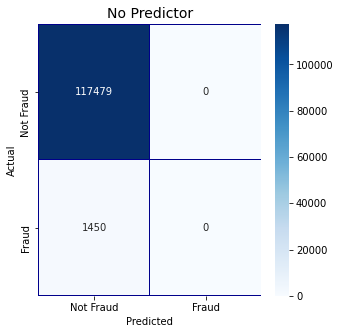

In [11]:
# plot the confusion matrix, good positive (fraud) and good negative (not fraud) are top left and bottom right
#
import matplotlib.pyplot as plt
import seaborn as sns
cm = pd.crosstab(l[target], l['baseline'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, 
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('No Predictor', fontsize=14)
plt.show()

In [12]:
# We can see above, no frauds are predicted. Bottom left is the problem.
# On to the real classification challenge.

In [13]:
# Define the columns we care about for the two types of data, rdb/transaction only versus full graph features


simple_predictors=['amount','my_cust', 'my_merch', 'my_cat'] # these are what we get from the payment system
my_predictors = simple_predictors

In [14]:
categorical_features_indices = np.where(train_df[my_predictors].dtypes == np.object)[0]
categorical_features_indices

array([1, 2, 3])

In [15]:
# Using the catboost classifier from yandex. Easy and performs really well. simple columns only.
from catboost import CatBoostClassifier

clf = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=10) #, od_wait=50) 
# grab the non-numeric features
categorical_features_indices = np.where(train_df[my_predictors].dtypes != np.float)[0]
#categorical_features_indices = np.where(train_df[my_predictors].dtypes == np.object)[0]
my_model = clf.fit(train_df[my_predictors], train_df[target],cat_features=categorical_features_indices,
                    eval_set=(test_df[my_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135317


0:	learn: 0.8823733	test: 0.8745813	best: 0.8745813 (0)	total: 217ms	remaining: 3m 37s
10:	learn: 0.8768897	test: 0.8715159	best: 0.8745813 (0)	total: 1.25s	remaining: 1m 52s
20:	learn: 0.8899764	test: 0.8830144	best: 0.8837296 (18)	total: 2.29s	remaining: 1m 46s
30:	learn: 0.9045218	test: 0.8936786	best: 0.8936786 (30)	total: 3.18s	remaining: 1m 39s
40:	learn: 0.9101042	test: 0.8962032	best: 0.8962032 (40)	total: 4.08s	remaining: 1m 35s
50:	learn: 0.9128286	test: 0.8969609	best: 0.8973568 (46)	total: 4.95s	remaining: 1m 32s
60:	learn: 0.9134096	test: 0.8999281	best: 0.8999324 (59)	total: 5.9s	remaining: 1m 30s
70:	learn: 0.9145459	test: 0.8988298	best: 0.8999324 (59)	total: 6.81s	remaining: 1m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8999323744
bestIteration = 59

Shrink model to first 60 iterations.


Predicted       0  1
Actual              
0          117479  0
1            1450  0


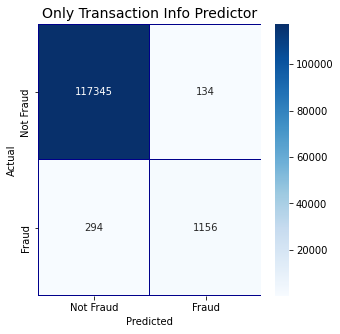

In [16]:
# Lets see the results by running the generated model against the validation set.
import matplotlib.pyplot as plt
import seaborn as sns

# So now we need to test the model against the validator
preds = clf.predict(valid_df[my_predictors]) 

cm1 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
#print(cm1)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm1, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Only Transaction Info Predictor', fontsize=14)
plt.show()

In [17]:
# What were the significant features in the model?
tmp = pd.DataFrame({'Feature': my_predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Important Features in Prediction',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [18]:
# This is the best we can do with inline aggregates.
aggregate_predictors =['amount', 'my_cust', 'my_merch', 'my_cat',
       'cust_sum', 'cust_max'
        , 'cust_num_t', 'cust_num_f'
        , 'merch_sum' # These are our graph synthesised features
        , 'merch_max'
        , 'merch_num_t', 'merch_num_f'
        , 'cat_sum' 
        , 'cat_max'
        ,'cat_num_t', 'cat_num_f'
        ,'cust_f_t', 'merch_f_t', 'cat_f_t'              ]
my_predictors = aggregate_predictors

In [19]:
# Using the catboost classifier from yandex. Easy and performs really well. simple columns only.
from catboost import CatBoostClassifier

clf = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=10) #, od_wait=50) 
# grab the non-numeric features
categorical_features_indices = np.where(train_df[my_predictors].dtypes != np.float)[0]
#categorical_features_indices = np.where(train_df[my_predictors].dtypes == np.object)[0]
# run the model
my_model = clf.fit(train_df[my_predictors], train_df[target],cat_features=categorical_features_indices,
                    eval_set=(test_df[my_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135317


0:	learn: 0.8901059	test: 0.8630016	best: 0.8630016 (0)	total: 214ms	remaining: 3m 33s
10:	learn: 0.9334761	test: 0.9283782	best: 0.9313454 (9)	total: 2.78s	remaining: 4m 9s
20:	learn: 0.9447630	test: 0.9409665	best: 0.9420776 (18)	total: 6s	remaining: 4m 39s
30:	learn: 0.9492133	test: 0.9428141	best: 0.9442829 (27)	total: 8.88s	remaining: 4m 37s
40:	learn: 0.9517133	test: 0.9464796	best: 0.9464881 (39)	total: 12s	remaining: 4m 40s
50:	learn: 0.9538781	test: 0.9472160	best: 0.9475907 (49)	total: 14.8s	remaining: 4m 34s
60:	learn: 0.9540130	test: 0.9483399	best: 0.9483399 (60)	total: 17.6s	remaining: 4m 31s
70:	learn: 0.9552743	test: 0.9487060	best: 0.9498171 (68)	total: 21.1s	remaining: 4m 35s
80:	learn: 0.9563084	test: 0.9490722	best: 0.9498171 (68)	total: 24.4s	remaining: 4m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9498171473
bestIteration = 68

Shrink model to first 69 iterations.


In [20]:
# Lets see the results by running the generated model against the validation set.
import matplotlib.pyplot as plt
import seaborn as sns

# So now we need to test the model against the validator
preds = clf.predict(valid_df[my_predictors]) 

cm2 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
print(cm1)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm2, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('With History', fontsize=14)
plt.show()

Predicted       0  1
Actual              
0          117479  0
1            1450  0
Predicted       0     1
Actual                 
0          117345   134
1             294  1156


In [21]:
# What were the significant features in the model?
tmp = pd.DataFrame({'Feature': my_predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Important Features in Prediction',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [22]:
# This includes the graph fraud contagion algorithm
graph_predictors =['amount', 'my_cust', 'my_merch', 'my_cat',
         'cust_sum', 'cust_max'
        , 'cust_num_t', 'cust_num_f'
        , 'merch_sum' # These are our graph synthesised features
        , 'merch_max'
        , 'merch_num_t', 'merch_num_f' 
        , 'cat_sum' 
        , 'cat_max'
        ,'cat_num_t', 'cat_num_f'
        ,'cust_f_t', 'merch_f_t', 'cat_f_t'   
                   , 'f_prev'
                   , 'f2_prev'
                  ]

#graph_predictors =[ 'cust_num_f', 'dist_fraud' ]

my_predictors = graph_predictors

In [23]:
np.where(train_df[my_predictors].dtypes != np.float)[0]

array([ 1,  2,  3,  6,  7, 10, 11, 14, 15, 19, 20])

In [24]:
# Using the catboost classifier from yandex. Easy and performs really well. simple columns only.
from catboost import CatBoostClassifier

clf = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=10) #, od_wait=50) 
# grab the non-numeric features
categorical_features_indices = np.where(train_df[my_predictors].dtypes != np.float)[0]
#categorical_features_indices = np.where(train_df[my_predictors].dtypes == np.object)[0]
# run the model
my_model = clf.fit(train_df[my_predictors], train_df[target],cat_features=categorical_features_indices,
                    eval_set=(test_df[my_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135317


0:	learn: 0.8966726	test: 0.8894429	best: 0.8894429 (0)	total: 215ms	remaining: 3m 34s
10:	learn: 0.9347503	test: 0.9365136	best: 0.9365136 (10)	total: 2.71s	remaining: 4m 3s
20:	learn: 0.9437304	test: 0.9487188	best: 0.9487401 (19)	total: 5.43s	remaining: 4m 12s
30:	learn: 0.9495301	test: 0.9505494	best: 0.9516562 (27)	total: 8.13s	remaining: 4m 14s
40:	learn: 0.9529491	test: 0.9523927	best: 0.9524055 (36)	total: 10.9s	remaining: 4m 16s
50:	learn: 0.9539889	test: 0.9516435	best: 0.9524055 (36)	total: 13.5s	remaining: 4m 11s
60:	learn: 0.9557048	test: 0.9538657	best: 0.9538700 (58)	total: 16.3s	remaining: 4m 11s
70:	learn: 0.9567474	test: 0.9545937	best: 0.9545979 (65)	total: 19.2s	remaining: 4m 10s
80:	learn: 0.9565314	test: 0.9538487	best: 0.9545979 (65)	total: 22.9s	remaining: 4m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.954597943
bestIteration = 65

Shrink model to first 66 iterations.


In [25]:
# Lets see the results by running the generated model against the validation set.
import matplotlib.pyplot as plt
import seaborn as sns

# So now we need to test the model against the validator
preds = clf.predict(valid_df[my_predictors]) 

cm3 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print ("Null Predictor")
print (cm)
print()
print ("Predictor Using Only Transaction Info")
print(cm1)
print()
print ("With History")
print(cm2)
print()
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm3, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('With Graph Predictor', fontsize=14)
plt.show()

Null Predictor
Predicted       0  1
Actual              
0          117479  0
1            1450  0

Predictor Using Only Transaction Info
Predicted       0     1
Actual                 
0          117345   134
1             294  1156

With History
Predicted       0     1
Actual                 
0          117424    55
1             169  1281



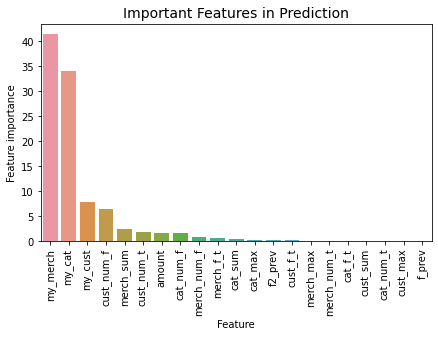

In [26]:
# What were the significant features in the model?
tmp = pd.DataFrame({'Feature': my_predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Important Features in Prediction',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   